# Qual é o melhor plano?

Você trabalha como analista para a empresa de telecomunicações Megaline. A empresa oferece aos clientes dois planos pré-pagos: Surf e Ultimate. O departamento comercial quer saber qual dos planos gera mais receita para ajustar o orçamento de publicidade.

Você vai realizar uma análise preliminar dos planos com base em uma pequena seleção de clientes. Você terá dados de 500 clientes da Megaline: que clientes são, de onde eles são, qual plano usam e o número de chamadas e mensagens realizadas em 2018. Seu trabalho é analisar o comportamento dos clientes e determinar qual plano pré-pago gera mais receita.

## Inicialização

In [1]:
# Carregando todas as bibliotecas
import pandas as pd
from math import factorial
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from scipy import stats as st
import calendar

## Carregue os dados

In [2]:
# Carregue os arquivos de dados em diferentes DataFrames
megaline_calls = pd.read_csv ('/datasets/megaline_calls.csv')
megaline_internet = pd.read_csv('/datasets/megaline_internet.csv')
megaline_messages = pd.read_csv('/datasets/megaline_messages.csv')
megaline_plans = pd.read_csv ('/datasets/megaline_plans.csv')
megaline_users = pd.read_csv ('/datasets/megaline_users.csv')

## Prepare os dados

In [3]:
megaline_calls.info()
megaline_calls['duration'] = np.ceil(megaline_calls ['duration'])
print (megaline_calls.sample(10))
print (megaline_calls.isna().sum())
print (megaline_calls.duplicated())
#Os dados não tem duplicados ou valores ausentes. Arredondei a duração da chamada para cima. Fiz um teste antes transformando os segundos em minutos mas a maioria dos valores ficou 0.0, estaria certo?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
              id  user_id   call_date  duration
14728   1060_110     1060  2018-08-24       7.0
129964  1467_200     1467  2018-12-22      11.0
43192   1157_221     1157  2018-07-21       3.0
12898    1056_41     1056  2018-08-12      12.0
32887   1123_245     1123  2018-09-16       0.0
53511   1192_438     1192  2018-10-25       5.0
89355     1326_6     1326  2018-09-06      14.0
12946    1056_89     1056  2018-12-15       0.0
15987   1062_227     1062  2018-07-09       3.0
122955  1434_267     1434  2018-11-27       7.0
id           0
user_id      0
call_date    0
duration 

In [4]:
megaline_internet.info() 
megaline_internet['gb_used'] = megaline_internet.pop('mb_used') #Troquei MG por GB
megaline_internet['gb_used'] = np.ceil(megaline_internet ['gb_used']) #Arredondei para cima
print (megaline_internet.sample(10))
print (megaline_internet.isna().sum())
print (megaline_internet.duplicated())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
             id  user_id session_date  gb_used
54084  1245_117     1245   2018-07-21     88.0
68108   1317_58     1317   2018-12-10      0.0
14323  1066_215     1066   2018-03-12    307.0
98529   1466_10     1466   2018-10-07     26.0
22885   1106_74     1106   2018-06-24    635.0
93903  1438_145     1438   2018-12-27    343.0
84654   1395_19     1395   2018-12-10    270.0
62134   1283_32     1283   2018-12-15    833.0
73483   1346_63     1346   2018-07-23     38.0
75587   1356_35     1356   2018-12-16    120.0
id              0
user_id         0
session_dat

In [5]:
megaline_messages.info()
print (megaline_messages.sample(10))
print (megaline_messages.isna().sum())
print (megaline_messages.duplicated())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
             id  user_id message_date
2596   1028_519     1028   2018-11-14
1104    1011_67     1011   2018-07-10
60242  1381_355     1381   2018-12-30
61286  1384_384     1384   2018-11-21
12122  1080_125     1080   2018-11-29
55073  1347_110     1347   2018-12-10
53782   1341_58     1341   2018-10-30
44988   1302_93     1302   2018-11-27
2695   1028_621     1028   2018-03-24
50892   1331_67     1331   2018-11-25
id              0
user_id         0
message_date    0
dtype: int64
0        False
1        False
2        False
3        False
4        False
         ...  
76046    False
76047    False
76048    False
76049    Fal

In [6]:
megaline_plans.info()
print (megaline_plans.sample())
print (megaline_plans.isna().sum())
print (megaline_plans.duplicated())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
messages_included        0
mb_

In [7]:
megaline_users.info()
print (megaline_users.sample(10))
print (megaline_users.isna().sum())
print (megaline_users.duplicated())
#Aqui existe dados Nan, pois indica que o usuário ainda está a usar o plano, não cancelou. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
     user_id first_name   last_name  age  \
120     1120    Abraham   Mcconnell   33   
305     1305      Gwenn       Gross   18   
387     1387   Raymonde        Lowe   28   
487     1487      Elton     Simpson   18   
95      1095    Lilliam    Alvarado   55   
97      1097    Deandre      Powell   27   
231     1231    Gaylord        Witt   57   
56      1056      Denis    Chandler   33   
447     1447      Ramon      Hester   62   
92   

## Planos

In [8]:
# Imprima informações gerais/resumo sobre o DataFrame dos planos
megaline_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [9]:
# Imprima uma amostra de dados dos planos
print (megaline_plans.head())


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


**Notas:** Só existem dois planos, portanto em relação a isso está correto. A tabela não aparenta ter dados nulos ou ausentes, entretanto a coluna "mb_per_month_included" deveria estar em gb conforme solicitado pela empresa.

## Corrija os dados

[Corrija problemas óbvios com os dados conforme as observações iniciais.]

In [10]:
megaline_plans['gb_per_month_included'] = megaline_plans.pop('mb_per_month_included') / 1024
megaline_plans.head()

,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,500,20,10,0.03,0.03,surf,15.0
1,1000,3000,70,7,0.01,0.01,ultimate,30.0


## Usuários

In [11]:
# Imprima informações gerais/resumo sobre o DataFrame dos usuários
megaline_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [12]:
# Imprima uma amostra de dados dos usuários
megaline_users.sample(5) #preferi usar o 'sample' para ser mais aleatório

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
395,1395,Leonard,Wooten,24,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-19,ultimate,NaN
459,1459,Santos,Head,40,"San Francisco-Oakland-Berkeley, CA MSA",2018-04-27,ultimate,NaN
204,1204,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN
252,1252,Mitsue,York,27,"Detroit-Warren-Dearborn, MI MSA",2018-06-10,surf,NaN
11,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN


[Descreva o que você nota sobre as informações gerais e sobre a amostra de dados impressa acima. Existem problemas (tipos de dados inadequados, dados ausentes, etc.) que precisam de mais investigação e alterações? Como isso pode ser corrigido?]

**Nota:** Na amostra de dados, podemos pereber que 4 dos 5 clientes adotaram o plano "surf" em vez do "ultimame". As idades são bem variadas, indo de 28 a 52.A coluna churn_date tem muitos valores "NaN" em razão dos planos ainda não terem acabados, pensando nisso, acredito que seja melhor trocar "NaN" por algo como "Ainda ativo", "Em andamento" para um melhor entendimento.

### Corrija os dados

[Corrija problemas óbvios com os dados conforme as observações iniciais.]

In [13]:
megaline_users['churn_date'] = megaline_users['churn_date'].fillna('Plano ainda ativo')
megaline_users.sample(5) #preferi usar o 'sample' para ser mais aleatório

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
103,1103,Moises,Weeks,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-07-01,surf,Plano ainda ativo
404,1404,Paulita,Conley,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-16,surf,Plano ainda ativo
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,Plano ainda ativo
414,1414,Georgianne,Herring,30,"Urban Honolulu, HI MSA",2018-03-03,surf,2018-09-01
316,1316,Lucilla,Weeks,59,"Tulsa, OK MSA",2018-05-21,surf,Plano ainda ativo


## Chamadas

In [14]:
# Imprima informações gerais/resumo sobre o DataFrame das chamadas
megaline_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# Imprima uma amostra de dados das chamadas
megaline_calls.sample(5) #preferi usar o 'sample' para ser mais aleatório

,id,user_id,call_date,duration
51724,1185_762,1185,2018-10-22,2.0
90472,1328_102,1328,2018-09-04,8.0
135143,1490_243,1490,2018-10-30,4.0
128380,1460_532,1460,2018-06-27,9.0
117410,1411_2,1411,2018-12-09,15.0


[Descreva o que você nota sobre as informações gerais e sobre a amostra de dados impressa acima. Existem problemas (tipos de dados inadequados, dados ausentes, etc.) que precisam de mais investigação e alterações? Como isso pode ser corrigido?]

**Notas:** Os dados paracem adequados, anteriormente arredondei os valores de "duration" para cima.". Não existem valores ausentes (como verificado anteriormente). A data está organizada de forma entendível, por aaaa-mm-dd.

### Corrija os dados

[Corrija problemas óbvios com os dados conforme as observações iniciais.]

In [16]:
megaline_calls['call_date'] = pd.to_datetime (megaline_calls['call_date'])

## Mensagens

In [17]:
# Imprima informações gerais/resumo sobre o DataFrame das mensagens
megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [18]:
# Imprima uma amostra dos dados das mensagens
megaline_messages.sample(5) #preferi usar o 'sample' para ser mais aleatório

,id,user_id,message_date
64417,1410_82,1410,2018-12-19
1574,1016_28,1016,2018-11-29
64736,1412_318,1412,2018-12-09
33866,1213_72,1213,2018-12-21
23959,1144_461,1144,2018-05-27


[Descreva o que você nota sobre as informações gerais e sobre a amostra de dados impressa acima. Existem problemas (tipos de dados inadequados, dados ausentes, etc.) que precisam de mais investigação e alterações? Como isso pode ser corrigido?]

**Notas:** Os dados parecem estar adequados, sem valores ausentes (como verificado anteriormente). Parece que os usuários mandam mais que uma mensagem por dia.

### Enriqueça os dados

[Inclua fatores adicionais aos dados se você acredita que eles podem ser úteis.]

In [19]:
#Não temos os dados, mas acredito que seria interessante conter o horário do envio das mensagens, assim poderiamos analisar qual horário e período os usuários mandam mais mensagens. 

## Internet

In [20]:
# Imprima informações gerais/resumo sobre o DataFrame da internet
megaline_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   gb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [21]:
#  Imprima uma amostra de dados para o tráfego da internet
megaline_internet.sample(5) #preferi usar o 'sample' para ser mais aleatório

,id,user_id,session_date,gb_used
19083,1085_157,1085,2018-10-11,345.0
16289,1073_194,1073,2018-11-28,267.0
61449,1279_63,1279,2018-12-30,0.0
69632,1325_34,1325,2018-12-14,0.0
99953,1474_21,1474,2018-09-15,273.0


[Descreva o que você nota sobre as informações gerais e sobre a amostra de dados impressa acima. Existem problemas (tipos de dados inadequados, dados ausentes, etc.) que precisam de mais investigação e alterações? Como isso pode ser corrigido?]

**Nota:** Os dados parecem estar adequados, sem valores ausentes (como verificado anteriormente). Já foi alterado a antiga coluna "mb_used" para "gb_used" e os valores também já tinham sido arredondados. Parece que a média de "gb_used" é bem variada, visto que um usuário usou 0 e outro 881.

## Estude as condições dos planos

[É fundamental entender como os planos funcionam, ou seja, como as cobranças dos usuários são feitas com base na assinatura. Sugerimos imprimir as informações sobre os planos para visualizar novamente as condições.]

In [22]:
# Imprima as condições dos planos e certifique-se de que elas fazem sentido para você
megaline_plans.head()

,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,500,20,10,0.03,0.03,surf,15.0
1,1000,3000,70,7,0.01,0.01,ultimate,30.0


## Agregue os dados por usuário

[Agora, como os dados estão limpos, os agregue por usuário e por período para ter apenas um registro dessas informações. Isso vai facilitar muito as próximas análises.]

In [23]:
# Calcule o número de chamadas feitas por cada usuário por mês. Salve o resultado.
megaline_calls['month'] = megaline_calls['call_date'].dt.month
calls_per_month = megaline_calls.groupby(['user_id', 'month'])['id'].count().reset_index(name = 'calls_count')
print (calls_per_month.sample(5))

      user_id  month  calls_count
1616     1358      6           57
900      1192     10           69
604      1130     12           71
1323     1291      9           83
1620     1358     10           64


In [24]:
# Calcule a quantidade de minutos gastos por cada usuário por mês. Salve o resultado.
min_waste = megaline_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index(name = 'min_waste')
print (min_waste.sample(10))

      user_id  month  min_waste
1793     1393     10       71.0
2101     1465      8      682.0
1090     1237     11      743.0
746      1160      5      626.0
2222     1493      8      373.0
1827     1400      8      529.0
1381     1305     11      536.0
176      1044     10      172.0
142      1039     11      491.0
1804     1396     11      279.0


In [25]:
# Calcule o número de mensagens enviadas por cada usuário por mês. Salve o resultado.
megaline_messages['message_date'] = pd.to_datetime(megaline_messages['message_date'])
megaline_messages['month'] = megaline_messages['message_date'].dt.month
sent = megaline_messages.groupby(['user_id','month'])['message_date'].count().reset_index(name= 'sent_messages')
print (sent)

      user_id  month  sent_messages
0        1000     12             11
1        1001      8             30
2        1001      9             44
3        1001     10             53
4        1001     11             36
...       ...    ...            ...
1801     1496      9             21
1802     1496     10             18
1803     1496     11             13
1804     1496     12             11
1805     1497     12             50

[1806 rows x 3 columns]


In [26]:
# Calcule o volume de tráfego de internet usado por cada usuário por mês. Salve o resultado.
megaline_internet['session_date'] = pd.to_datetime(megaline_internet['session_date'])
megaline_internet['month'] = megaline_internet['session_date'].dt.month
net_trafic = megaline_internet.groupby (['user_id', 'month'])['gb_used'].sum().reset_index (name = "net_trafic")
print (net_trafic)

      user_id  month  net_trafic
0        1000     12      1903.0
1        1001      8      6929.0
2        1001      9     13333.0
3        1001     10     22356.0
4        1001     11     18524.0
...       ...    ...         ...
2272     1498     12     23160.0
2273     1499      9     13004.0
2274     1499     10     19515.0
2275     1499     11     16834.0
2276     1499     12     22091.0

[2277 rows x 3 columns]


[Coloque os dados agregados em um DataFrame para que cada registro nele represente o que cada usuário consumiu em um determinado mês.]
#Nota aluno: não entendi o que é para fazer

In [27]:
# Junte os dados de chamadas, minutos, mensagens e internet com base em user_id e month
merged = calls_per_month.merge (min_waste, on = ['user_id', 'month'], how = 'outer')
merged = merged.merge (sent, on=['user_id', 'month'], how = 'outer')
merged = merged.merge (net_trafic, on=['user_id', 'month'], how = 'outer')
print (merged.head())

   user_id  month  calls_count  min_waste  sent_messages  net_trafic
0     1000     12         16.0      124.0           11.0      1903.0
1     1001      8         27.0      182.0           30.0      6929.0
2     1001      9         49.0      315.0           44.0     13333.0
3     1001     10         65.0      393.0           53.0     22356.0
4     1001     11         64.0      426.0           36.0     18524.0


In [28]:
# Adicione as informações sobre o plano
merged = merged.merge(
    megaline_users[['user_id', 'plan']],
    on = 'user_id',
    how = 'left'
)

print (merged.head())

   user_id  month  calls_count  min_waste  sent_messages  net_trafic      plan
0     1000     12         16.0      124.0           11.0      1903.0  ultimate
1     1001      8         27.0      182.0           30.0      6929.0      surf
2     1001      9         49.0      315.0           44.0     13333.0      surf
3     1001     10         65.0      393.0           53.0     22356.0      surf
4     1001     11         64.0      426.0           36.0     18524.0      surf


[Calcule a receita mensal para cada usuário: subtraia o limite gratuito do pacote do número total de chamadas, mensagens de texto e dados; multiplique o resultado pelo valor do plano; adicione o preço mensal dependendo do plano. Importante: isso talvez não seja tão simples e necessite de várias linhas, considerando as condições do plano. Portanto, não se preocupe se você passar algum tempo nesta etapa.]

In [29]:
# Calcule a receita mensal para cada usuário

df_users_monthly = (
    calls_per_month
    .merge(min_waste, on=['user_id', 'month'], how='outer')  # Junta os minutos
    .merge(sent, on=['user_id', 'month'], how='outer')  # Junta as mensagens
    .merge(net_trafic, on=['user_id', 'month'], how='outer')  # Junta o uso de internet
    .merge(megaline_users[['user_id','city']], on='user_id', how='left')  # Adiciona a cidade de cada usuário
    .fillna(0)  # Preenche valores ausentes com 0 (caso o usuário não tenha usado algum serviço no mês)
)


df_users_monthly_plans = df_users_monthly.merge(megaline_users[['user_id', 'plan']], on='user_id', how='left')

def calculate_revenue(row):
    plan_name = row['plan']
    calls_used = row['min_waste']
    messages_sent = row['sent_messages']
    internet_used_mb = row['net_trafic']

    plan_details = megaline_plans[megaline_plans['plan_name'] == plan_name].iloc[0]


    minutes_included = plan_details['minutes_included']            # Minutos incluídos no plano
    messages_included = plan_details['messages_included']       # Mensagens incluídas no plano
    mb_included = plan_details['gb_per_month_included']                # Internet incluída em MB
    usd_monthly_pay = plan_details['usd_monthly_pay']              # Valor fixo mensal do plano

    usd_per_minute = plan_details['usd_per_minute']                # Custo por minuto adicional
    usd_per_message = plan_details['usd_per_message']              # Custo por mensagem adicional
    usd_per_gb = plan_details['usd_per_gb']                        # Custo por GB adicional

    extra_minutes_cost = max(0, (calls_used - minutes_included)) * usd_per_minute

    extra_messages_cost = max(0, (messages_sent - messages_included)) * usd_per_message

    extra_internet_cost = max(0, (np.ceil((internet_used_mb - mb_included) / 1024)) * usd_per_gb)

    total_revenue = usd_monthly_pay + extra_minutes_cost + extra_messages_cost + extra_internet_cost

    return total_revenue

# Aplica a função a cada linha do DataFrame para calcular a receita mensal de cada usuário
df_users_monthly_plans['monthly_revenue'] = df_users_monthly_plans.apply(calculate_revenue, axis=1)

# Exibe as 20 primeiras linhas do DataFrame resultante
print(df_users_monthly_plans.head(20))

    user_id  month  calls_count  min_waste  sent_messages  net_trafic  \
0      1000     12         16.0      124.0           11.0      1903.0   
1      1001      8         27.0      182.0           30.0      6929.0   
2      1001      9         49.0      315.0           44.0     13333.0   
3      1001     10         65.0      393.0           53.0     22356.0   
4      1001     11         64.0      426.0           36.0     18524.0   
5      1001     12         56.0      412.0           44.0     19398.0   
6      1002     10         11.0       59.0           15.0      6559.0   
7      1002     11         55.0      386.0           32.0     19364.0   
8      1002     12         47.0      384.0           41.0     14416.0   
9      1003     12        149.0     1104.0           50.0     27069.0   
10     1004      5         21.0      193.0            7.0      6554.0   
11     1004      6         44.0      275.0           18.0     20702.0   
12     1004      7         49.0      381.0         

## Estude o comportamento do usuário

[Calcule algumas estatísticas descritivas úteis para os dados agregados, o que costuma revelar uma imagem geral capturada pelos dados. Desenhe gráficos úteis para ajudar na compreensão. Já que a tarefa principal é comparar os planos e decidir qual é mais rentável, as estatísticas e os gráficos devem ser calculados por plano.]

[Existem dicas relevantes nos comentários para as chamadas. Essas dicas não foram fornecidas para as mensagens e internet, mas o princípio do estudo estatístico é o mesmo em todos os casos.]

### Chamadas

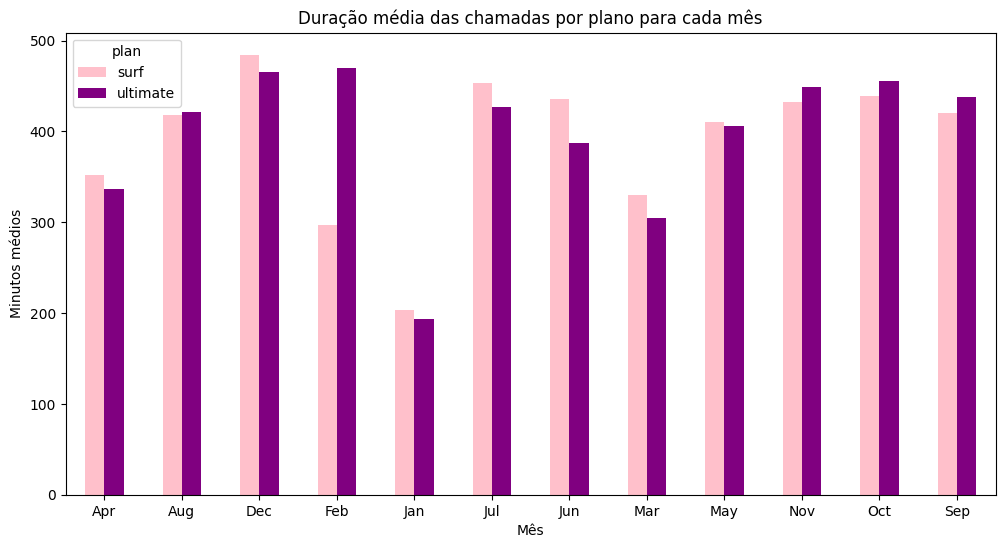

In [ ]:
import calendar  # Para obter os nomes dos meses

# Agrupa por plano e mês, calculando a média de minutos desperdiçados
avg_minutes = merged.groupby(['plan', 'month'])['min_waste'].mean().reset_index()

# Mapeia os números dos meses (1-12) para nomes ('Jan', 'Feb', ...)
avg_minutes['month_name'] = avg_minutes['month'].apply(lambda x: calendar.month_abbr[int(x)])

# Reordena os dados pelo número do mês (para manter a ordem correta)
avg_minutes = avg_minutes.sort_values(by='month')

# Faz o pivot usando os nomes dos meses como índice
avg_minutes_pivot = avg_minutes.pivot(index='month_name', columns='plan', values='min_waste')

# Gera o gráfico de barras
avg_minutes_pivot.plot(
    title='Duração média das chamadas por plano para cada mês',
    xlabel='Mês',
    ylabel='Minutos médios',
    kind='bar',
    rot=0,
    figsize=(12, 6),
    color=['pink', 'purple']
)

plt.show()


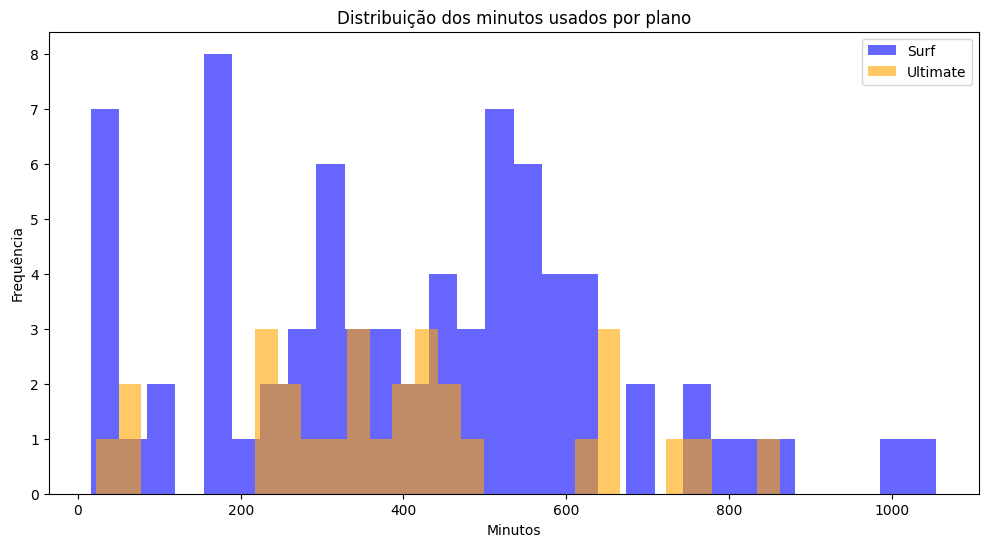

In [31]:
# Compare o número de minutos que os usuários de cada plano necessitam a cada mês. Construa um histograma.
month = 5
surf = merged[(merged['plan'] == 'surf') & (merged['month'] == month)]['min_waste']
ultimate = merged[(merged['plan'] == 'ultimate') & (merged['month'] == month)]['min_waste']

plt.figure(figsize=(12,6))

plt.hist(surf, bins=30, alpha=0.6, label='Surf', color='blue')
plt.hist(ultimate, bins=30, alpha=0.6, label='Ultimate', color='orange')

plt.title('Distribuição dos minutos usados por plano')
plt.xlabel ('Minutos')
plt.ylabel ('Frequência')
plt.legend()
plt.show()


[Calcule a média e a variância da duração das chamadas para refletir se os usuários de cada plano possuem comportamentos diferentes sobre as chamadas.]

In [32]:
# Calcule a média e a variância da duração mensal das chamadas
calls = merged.groupby('month')['min_waste'].agg(['mean', 'var']).reset_index()
print (calls)

    month        mean           var
0       1  196.666667  13135.866667
1       2  366.333333  56978.380952
2       3  321.171429  43378.499160
3       4  347.197183  45620.531992
4       5  409.125000  52828.673544
5       6  420.361702  42344.746809
6       7  444.944134  63782.244052
7       8  418.956522  52363.369280
8       9  425.942238  48325.605347
9      10  443.988131  50314.047478
10     11  437.570720  52021.061529
11     12  478.269565  60020.023037


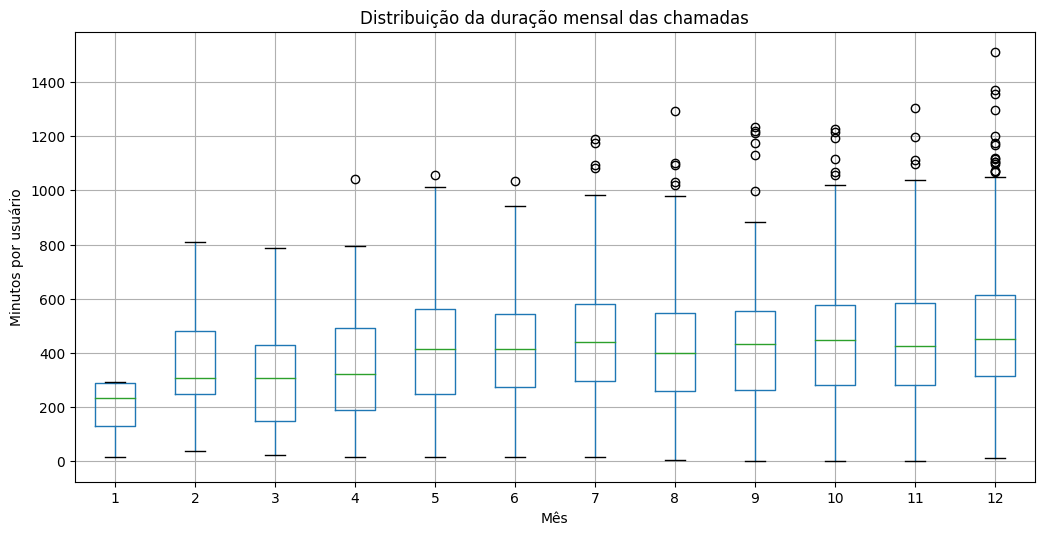

In [ ]:

# Faça um diagrama de caixa para visualizar a distribuição da duração mensal das chamadas

merged.boxplot(column='min_waste', by= 'month', figsize = (12,6))

plt.title('Distribuição da duração mensal das chamadas') ##Ajustado para plt.title
plt.suptitle('')
plt.xlabel('Mês')
plt.ylabel('Minutos por usuário')
plt.show()


O plano "surf" é muito mais usado do que o plano "ultimate". Sendo que os usuários do plano 'surf' usam muito mais minutos, além disso há uma variação mensal de minutos usados. 

### Mensagens

In [35]:
# Compare o número de mensagens que os usuários de cada plano costumam enviar a cada mês
msg = merged.groupby(['plan', 'month'])['sent_messages'].mean().reset_index()
print (msg.sample(10))

        plan  month  sent_messages
15  ultimate      4      28.937500
7       surf      8      37.596774
21  ultimate     10      46.977528
13  ultimate      2      25.166667
12  ultimate      1      20.666667
20  ultimate      9      45.901408
19  ultimate      8      47.929825
14  ultimate      3      34.714286
6       surf      7      35.945055
18  ultimate      7      41.212766


In [36]:
# Compare a quantidade de tráfego de internet consumido pelos usuários por plano
internet = merged.groupby(['plan', 'month'])['net_trafic'].mean().reset_index()
print (internet.sample(10))

        plan  month    net_trafic
17  ultimate      6  15355.106383
20  ultimate      9  16989.395349
7       surf      8  17132.125786
14  ultimate      3  18340.250000
15  ultimate      4  16140.476190
21  ultimate     10  17801.123810
6       surf      7  16943.208333
23  ultimate     12  18344.735099
3       surf      4  12243.061224
11      surf     12  18211.053628


**Conclusão:**
Os usuários do plano "ultimate" tendem a gastar mais dados do que os usuários do plano "surf", como por exemplo: no mes 4, os usuários do plano "ultimate" usaram 16140.476190 e do plano 'surf' 12243.061224, com uma diferença de 3.897.414.966 dados. Além disso, o uso de dados cresce em alguns meses, pode estar ligados a promoções, epocas do ano...

[Formule conclusões sobre como os usuários costumam consumir o tráfego da internet. O comportamento é diferente dependendo do plano?]

## Receita

[Da mesma forma que você estudou o comportamento dos usuários, descreva estatisticamente as receitas dos planos.]

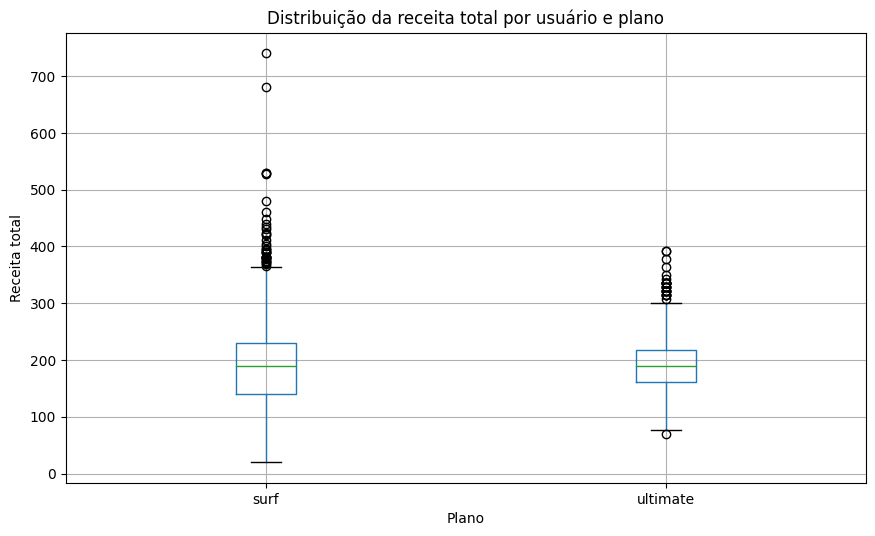

In [ ]:
df_users_monthly_plans.boxplot(column='monthly_revenue', by='plan', figsize = (10,6))

plt.suptitle('')
plt.title('Distribuição da receita total por usuário e plano')
plt.xlabel('Plano')
plt.ylabel('Receita total')
plt.show()

Os usuários do plano "surf" tem uma mediana de receita mais alta que do plano 'ultimate', ous seja, em média os usuários do 'surf' constumam gerar mais receita indivudual. Muitos usuários do plano 'surf' ultrapassam os limites do plano (pontinhos) já do plano 'ultimate' não são tantos.


[Formule conclusões sobre como a receita difere entre os planos.]

## Teste hipóteses estatísticas

[Teste a hipótese de que a receita média dos usuários dos planos Ultimate e Surf são diferentes.]

[Formule as hipóteses nula e alternativa, escolha o teste estatístico, escolha o valor alfa.]

In [47]:
# Teste as hipóteses
#Hipótese nula: A receita média dos usuários do plano surf e ultimate são igual
#Hipótese alternativa: A receita média dos usuários do plano surf e ultimate são diferentes
alpha = 0.05
surf_revenue = df_users_monthly_plans[df_users_monthly_plans['plan'] == 'surf']['monthly_revenue']
ultimate_revenue = df_users_monthly_plans[df_users_monthly_plans['plan'] == 'ultimate']['monthly_revenue']

results = st.ttest_ind(surf_revenue,ultimate_revenue, equal_var = False )
print ('valor-p:', results.pvalue)

if results.pvalue < alpha:
    print ('Rejeitamos a hipótese nula')
else: 
    print ('Aceitamos a hipóstese nula')

valor-p: 0.4251791379266495
Aceitamos a hipóstese nula


[Teste a hipótese de que a receita média dos usuários da área de NY-NJ difere dos usuários das demais regiões.]

In [40]:
df = df_users_monthly_plans.merge(megaline_users[['user_id', 'city']], on='user_id', how='left')
ny_nj = df_users_monthly_plans[df_users_monthly_plans['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue']
other_city = df_users_monthly_plans[df_users_monthly_plans['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue']

results = st.ttest_ind(ny_nj,other_city, equal_var = False )
print (results)

Ttest_indResult(statistic=0.030577765842188506, pvalue=0.9756171772470743)


In [41]:
#Hipotese nula: o valor da receita média dos usuários da área de NY-NJ é igual a outras regiões
#Hipótese alternativa: o valor da receita média dos usuários da área de NY-NJ difere de outras regiões
alpha = 0.05
if results.pvalue < alpha:
    print ('Rejeitamos a hipótese nula')
else:
    print ('Aceitamos a hipóstese nula')


Aceitamos a hipóstese nula


## Conclusão geral

Como sempre, os projetos vão evoluindo, usamos mais coisas a cada projeto o que aumenta a dificuldade (como nos exercícios que não soube fazer ou arrumar). Com novos dados, fiz o seu pré-processamento, verificando valores ausentes e duplicados, fiz também as conversões necessárias, como megabyte para gigabyte e segundos para minutos. Além disso, arrendondei os valores que haviam sido solictados e unifiquei colunas. Fiz alguns agrupamentos para entender o comportamento dos usuários, criei novas variáveis, e analisei as principais diferenças entre os usuários do plano 'surf' e 'ultimate'. Testei as hipóteses nulas e alternativas que ajudam a dar os próximos passos para empresa, como por exemplo: talvez revisar o modelo de preços do Surf para equilibrar lucro e satisfação do cliente e realizar análises adicionais segmentadas por região ou perfil de cliente para campanhas personalizadas.